# Sutton 
 
## Chapter 4 - Dynamic Programming


In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import numpy.random 
import math

## Jack's Car Rental
### By random sampling

In [2]:
#Jacks Car Rental using random sampling

def draw_poisson(lamb):
    """ Samples from poission distribution"""
    return np.random.poisson(lamb)

def evaluate(NUM_TRIALS = 1000):
    """ Evalulate the current policy using via simulation. """
    
    # the goal here is to evalulate the EV for each given state given the rules of the game.
    
    # this is the number of trials to perform.  Higher numbers will give better results, but will
    # be slower.
    #NUM_TRIALS = 1000
    
    # number of days to simulate, because we are using discount rate 50 days will be sufficent.
    NUM_DAYS = 10
    
    for x in range(21):
        for y in range(21):     
            value = 0.0
            for i in range(NUM_TRIALS):
                # reset the state
                cars_a = x
                cars_b = y
                
                for day in range(NUM_DAYS):
                    
                    discount = 0.9 ** day
                    
                    # cars get rented
                    rent_a = min(draw_poisson(request_lambda[0]), cars_a)
                    rent_b = min(draw_poisson(request_lambda[1]), cars_b)
                    value += (rent_a * 10 + rent_b * 10) * discount
                    cars_a -= rent_a
                    cars_b -= rent_b
                    
                    # cars get returned
                    cars_a += draw_poisson(returns_lambda[0])
                    cars_b += draw_poisson(returns_lambda[1])
                    
                    cars_a = min(cars_a, 20)
                    cars_b = min(cars_b, 20)
                    
                    # cars get transfered
                    transfer = pi[cars_a, cars_b]
                    cars_a -= transfer
                    cars_b += transfer
                    
                    value -= (2 * transfer) * discount
                    
            V[x, y] = value / NUM_TRIALS
                    
def improve():
    """ Step 3. Policy Improvement. """
    # 3. Policy Improvement
    policy_stable = True
    for x in range(20+1):
        for y in range(20+1):
            b = pi[x, y]
            # pick the best action...
            best_a = 0
            best = -9999
            for a in range(-5, 5+1):
                _x = x-a
                _y = y+a
                if _x < 0 or _y < 0:
                    continue
                if _x > 20 or _y > 20:
                    continue
                gain = V[_x, _y] - abs(a) * 2
                if gain > best:
                    best = gain
                    best_a = a
            pi[x, y] = best_a
            if best_a != b:
                policy_stable = False
    return policy_stable

Value


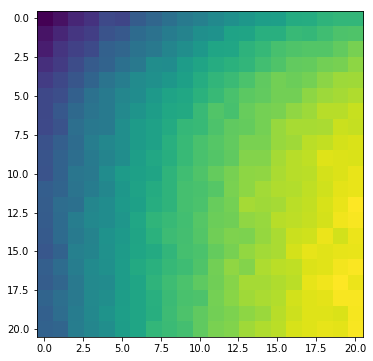

Policy


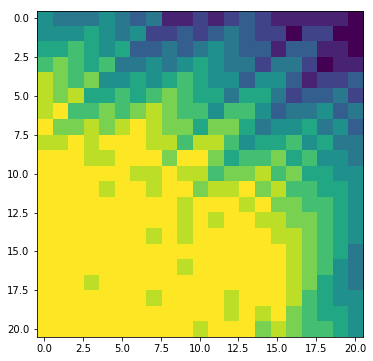

In [227]:
V = np.zeros((21, 21))
pi = np.zeros((21, 21), dtype = np.int32) # our policy, how many cars to move in each state.

request_lambda = [3,4]
returns_lambda = [3,2]

gamma = 0.9

evaluate(250)
improve()

print("Value")
plt.imshow(V.copy(), interpolation='nearest')
plt.show()

print("Policy")
plt.imshow(pi.copy(), interpolation='nearest')
plt.show()

### By DP

In [3]:
"""
    Find optimal policy in the "Jack's Car Rental" problem 
    via policy iteration.
"""

# V[s] is our estimated value at state s
# pi[s] is ... 

# 1. Initialize state arbitrarily to 0 for all s $\in$ S

poisson_cache = {}
exp_cache = {}

def poisson(n, lam):
    key = (n, lam)
    if key in poisson_cache:
        return poisson_cache[key] 
    result = (lam**n)/(math.factorial(n))*math.exp(-lam) if n >= 0 else 0
    poisson_cache[key] = result
    return result

def poisson_gteq(n, lam):
    prob = 1
    if n <= 0:
        return 1
    for i in range(n):
        prob -= poisson(i, lam)
    return prob

def expectation(a, b, action, lambda1, lambda2):
    """ returns probability, and expected reward we will go from having a cars to b cars, 
        given the "action" cars are transfered to us, incomming lambda, and outgoing lambda. """
    
    key = (a, b, action, lambda1, lambda2)
    
    if key in exp_cache:
        return exp_cache[key]
    

    # order is:
    # transfer cars
    # cars rented out
    # cars returned
    
    prob = 0
    reward = 0
    # step through possiable number of cars being rented.
    for n in range(0, 20):
        
        # start with initial cars, plus amount transfered
        cars = a + action 

        # cap to 0 cars... we don't get paid for more than that though.
        rented = min(n, cars)
        
        # now rent out n cars
        cars -= rented
        
        # we can hold only 20 cars
        cars = min(20, cars)

        # if we are aiming for the boundary 20 car limit then we need to consider all delta's greater than or equal to
        # this.
        capped = (b == 20)
                    
        # now condition on ending up with b cars
        delta = b-cars

        if capped:
            arrive_prob = poisson_gteq(delta, lambda1)  # probability that delta cars are returned (and thus we end up with b cars)
        else:
            # probability that delta cars are returned (and thus we end up with b cars)
            arrive_prob = poisson(delta, lambda1)  
            
        rented_prob = poisson(n, lambda2)      # probability that n cars were rented out
        
        prob += arrive_prob * rented_prob
        reward += (rented*10) * arrive_prob * rented_prob
    
    # condition on event occuring.
    reward = reward / prob if prob != 0 else 0
    
    exp_cache[key] = (prob, reward)
        
    return prob, reward

def nice_print(X, multiplier = 1.0):
    for y in range(21):
        s = ""
        for x in range(21):
            s += "{0:.0f}".format(X[20 - y, x] * multiplier).ljust(4)
        print(s)
        
def small_print(X):
    for y in range(11):
        s = ""
        for x in range(11):    
            s += "{0:.0f}".format(X[20-(y*2), (x*2)]).ljust(4)
        print(s)

In [8]:
# x is the number of cars at lot 1
# y is the number of cars at lot 2
# V[x,y] is our estimated value at a given state (x,y)
# pi[x,y] is our policy

def evaluate():
    """ Step 2. Evalulate the policy. """
    converge = False
    
    for i in range(100):
        old_V = V.copy()    
        
        for x in range(20+1):
            for y in range(20+1):
                
                # evalulate all new states
                V[x,y] = 0
                
                for destx in range(20+1):
                    for desty in range(20+1):

                        # the probability of entering into this new state given our current policy.
                        action = pi[x,y]
                        
                        p1, reward1 = expectation(x, destx, -action, request_lambda[0], returns_lambda[0])
                        p2, reward2 = expectation(y, desty, action, request_lambda[1], returns_lambda[1])
                        
                        p = p1*p2
                        reward = reward1 + reward2 - abs(action) * 2
                                                
                        # bellman
                        V[x,y] += p * (reward + gamma * old_V[destx, desty])
                                        
        delta = np.max(np.abs(V - old_V))
        if delta < 1e-4: # set to 0.001 for better peformance, just a little slower.
            converge = True
            return
        
    print("Did not converge! delta = {0}".format(delta))

def improve():
    """ Step 3. Policy Improvement. """
    # 3. Policy Improvement
    policy_stable = True
    for x in range(20+1):
        for y in range(20+1):
            b = pi[x, y]
            # pick the best action...
            best_a = 0
            best = -9999
            for a in range(-5, 5+1):
                _x = min(20, x-a)
                _y = min(20, y+a)
                if _x < 0 or _y < 0:
                    continue
                gain = V[_x, _y] - abs(a) * 2
                if gain > best:
                    best = gain
                    best_a = a
            pi[x, y] = best_a
            if best_a != b:
                policy_stable = False
    return policy_stable

Iteration 1:
Did not converge! delta = 0.0014313358913113916
Value
473 489 495 497 497 497 497 497 497 497 497 
473 488 495 496 497 497 497 497 497 497 497 
472 488 494 495 496 496 496 496 496 496 496 
471 486 492 494 494 494 494 494 494 494 494 
468 484 490 492 492 492 492 492 492 492 492 
465 480 486 488 488 489 489 489 489 489 489 
460 475 481 483 483 483 484 484 484 484 484 
452 468 474 476 476 476 476 476 476 476 476 
442 457 463 465 465 465 465 465 465 465 465 
426 442 448 450 450 450 450 450 450 450 450 
407 423 429 430 431 431 431 431 431 431 431 


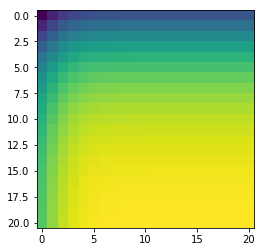

Policy
3   1   0   0   0   0   0   0   0   0   0   
3   1   0   0   0   0   0   0   0   0   0   
3   1   0   0   0   0   0   0   0   0   0   
3   1   0   0   0   0   0   0   0   0   0   
2   1   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   
2   0   0   -1  -2  -2  -2  -2  -2  -2  -2  
1   0   0   -2  -3  -4  -4  -4  -4  -4  -4  
0   0   -1  -2  -4  -5  -5  -5  -5  -5  -5  
0   0   -2  -3  -4  -5  -5  -5  -5  -5  -5  
0   -1  -2  -4  -5  -5  -5  -5  -5  -5  -5  


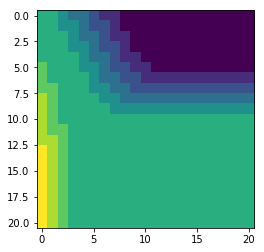

Iteration 2:
Value
488 492 496 498 498 498 498 498 498 498 498 
487 492 496 497 498 498 498 498 498 498 498 
485 491 495 497 497 497 497 497 497 497 497 
483 489 494 496 496 496 496 496 496 496 496 
480 487 492 494 494 494 494 494 494 494 494 
477 484 490 492 492 492 492 492 492 492 492 
472 481 487 488 488 488 488 488 488 488 488 
463 476 482 483 484 484 484 484 484 484 484 
452 468 474 478 479 480 480 480 481 481 481 
439 455 464 470 474 476 477 477 477 477 477 
420 437 451 460 466 470 472 472 473 473 473 


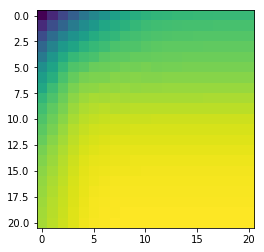

Policy
0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0   
0   1   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   -1  -1  -1  -1  -1  


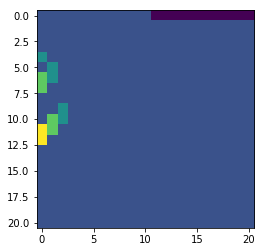

Iteration 3:
Value
474 489 495 497 497 497 497 497 497 497 497 
473 489 495 496 497 497 497 497 497 497 497 
472 488 494 496 496 496 496 496 496 496 496 
471 486 492 494 494 494 494 494 494 494 494 
476 484 490 492 492 492 492 492 492 492 492 
465 480 487 488 489 489 489 489 489 489 489 
460 476 482 483 484 484 484 484 484 484 484 
453 468 475 476 477 477 477 477 477 477 477 
442 457 464 466 466 466 466 466 466 466 466 
427 442 449 450 451 451 451 451 451 451 451 
408 423 430 431 432 432 440 440 440 440 440 


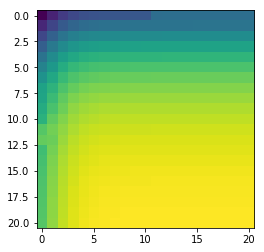

Policy
3   1   0   0   0   0   0   0   0   0   0   
3   1   0   0   0   0   0   0   0   0   0   
3   1   0   0   0   0   0   0   0   0   0   
3   1   0   0   0   0   0   0   0   0   0   
0   1   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   
2   0   0   -1  -1  -2  -2  -2  -2  -2  -2  
0   0   0   -2  -3  -3  -4  -4  -4  -4  -4  
0   0   -1  -2  -4  -5  -5  -5  -5  -5  -5  
0   0   -2  -3  -4  -5  -5  -5  -5  -5  -5  
0   -1  -2  -4  -5  -5  -5  -5  -5  -5  -5  


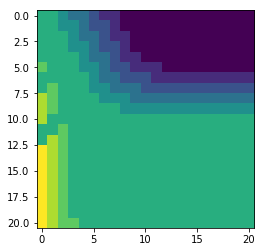

Iteration 4:
Value
488 492 496 498 498 498 498 498 498 498 498 
487 492 496 497 498 498 498 498 498 498 498 
485 491 495 497 497 497 497 497 497 497 497 
483 489 494 496 496 496 496 496 496 496 496 
471 487 493 494 494 494 494 494 494 494 494 
477 484 490 492 492 492 492 492 492 492 492 
472 481 487 488 488 488 488 488 488 488 488 
460 476 482 483 484 484 484 484 484 484 484 
452 468 475 478 479 480 480 481 481 481 481 
439 455 464 471 474 476 477 477 477 477 477 
420 437 451 460 467 471 472 473 473 473 473 


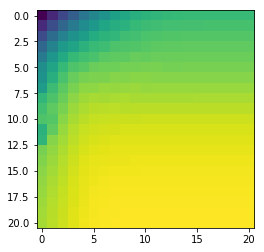

Policy
0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0   
0   1   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   0   0   0   0   0   
0   0   0   0   0   0   -1  -1  -1  -1  -1  


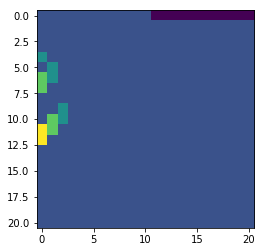

Iteration 5:
Value
474 489 495 497 497 497 497 497 497 497 497 
473 489 495 496 497 497 497 497 497 497 497 
472 488 494 496 496 496 496 496 496 496 496 
471 486 492 494 494 494 494 494 494 494 494 
476 484 490 492 492 492 492 492 492 492 492 
465 480 487 488 489 489 489 489 489 489 489 
460 476 482 483 484 484 484 484 484 484 484 
453 468 475 476 477 477 477 477 477 477 477 
442 457 464 466 466 466 466 466 466 466 466 
427 442 449 450 451 451 451 451 451 451 451 
408 423 430 431 432 432 440 440 440 440 440 


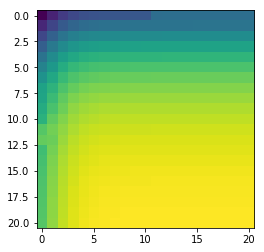

Policy
3   1   0   0   0   0   0   0   0   0   0   
3   1   0   0   0   0   0   0   0   0   0   
3   1   0   0   0   0   0   0   0   0   0   
3   1   0   0   0   0   0   0   0   0   0   
0   1   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   
2   0   0   -1  -1  -2  -2  -2  -2  -2  -2  
0   0   0   -2  -3  -3  -4  -4  -4  -4  -4  
0   0   -1  -2  -4  -5  -5  -5  -5  -5  -5  
0   0   -2  -3  -4  -5  -5  -5  -5  -5  -5  
0   -1  -2  -4  -5  -5  -5  -5  -5  -5  -5  


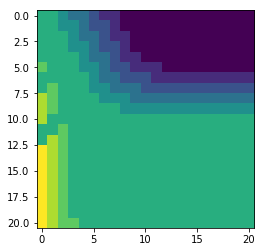

In [10]:
"""
The day goes like this.

we start in state (x,y) where x is the number of cars in lot1, and y is the number of cars in lot2.

Some number of cars are hired (we can only hire up to as many cars are avaliable)
Some number of cars are returned (these can not be used, but will effect our new state)
We move some number of cars between the lots, at a cost of $2 per car.

If there are ever more than 20 cars at a lot, these cars vanish.
We can move a maximum of 5 cars between lots per day.

"""

V = np.zeros((21, 21))
pi = np.zeros((21, 21), dtype = np.int32) # our policy, how many cars to move in each state.

request_lambda = [3,4]
returns_lambda = [3,2]

gamma = 0.9
    
for i in range(5):
    print("Iteration {0}:".format(i+1))
    evaluate()
    stable = improve()   
    
    print("Value")
    small_print(V)
    plt.imshow(V.copy(), interpolation='nearest')
    plt.show()

    print("Policy")
    small_print(pi)
    plt.imshow(pi.copy(), interpolation='nearest')
    plt.show()
    
    if stable:
        print("Solution stable.")
        break

# Gamblers Problem

Every turn we decide how much money to bet.
We then have p chance of doubling the money, and 1-p of loosing it.
The goal is to get to `$`100, and we can only bet integer amounts.

State are our current capital `[`1..99]

Action, state pairs are how much we bet given current captial.

Reward is 1 if we win (get `$`100), and 0 if we loose (reduce to `$`0)

In [137]:
def evaluate():    
    for i in range(1000):
        old_V = V.copy()
        # go through each state and update our value estimate
        for s in range(1,99+1):
            bet = pi[s]
            win = p * old_V[s + bet]
            loose = (1-p) * old_V[s - bet]
            V[s] = win + loose
        delta = np.max(np.abs(old_V - V))
        if delta < 1e-8:
            return
    print("[warning] did not converge, delta = {0}".format(delta))
    

def improve():
    old_pi = pi.copy()
    for s in range(1,99+1):
        # just pick the best option avaliable
        best_value = -999
        best_bet = 0
        for bet in range(1,s+1):
            if bet + s > 100:
                continue
            value = p * V[s+bet] + (1-p) * V[s-bet]
            # we need to beat the best value by a small margin, if we don't do this
            # we get small imperfections in the final solution (probably due to rounding errors)
            if value > best_value+1e-6:
                best_value = value
                best_bet = bet
                
        pi[s] = best_bet
    return (np.max(np.abs(old_pi-pi)) == 0)


In [100]:
def plot_pi(pi):
    plt.plot(range(0,101),pi)
    
def plot_value(V):
    plt.plot(range(0,101),[x*100 for x in V])


In [152]:
# in this case we have 100 states 
V = np.zeros((101), dtype = np.float64)
V[100] = 1.0

# policy is how much to gamble at a given state.
pi = np.zeros((101), dtype = np.int32)

p = 0.55

for i in range(1000):
    evaluate()
    stable = improve()   
  
    if i < 3:
        print("Iteration {0}:".format(i+1))
        plot_pi(pi)
        plot_value(V)
        plt.show()
    
    if stable:
        print("Solution stable after {0} iterations.".format(i))
        break

print("Final solution:")

plot_pi(pi)
plot_value(V)
plt.show()

print(pi)
        

IndexError: too many indices for array

Solutions for p < 0.5 are all equiv, however low values of p (<0.1) are dificualt to verify.

For p >= 0.5 we win in general, and so betting $1 is optimal.
